In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 36 kB/s 
     |████████████████████████████████| 198 kB 41.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=86de48e6156bd3142e2043c001c05d4ffa402bd70c9756475ff1a651f0dd2eda
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [ ]:
#Read csv file to dataframe
#=====your code here==========
from pyspark import SparkContext 
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

spark = SparkSession \
    .builder \
    .appName("Classification") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/drive/My Drive/Data/AMZN-data.csv')
#===============================
data.show(3)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+----------+----------+-----------+------------------+-----+------------------+
|     date0|     date1|close_value|              mean|count|        normalized|
+----------+----------+-----------+------------------+-----+------------------+
|2015-01-01|2015-01-01|     310.35|0.4885496183206106|  131|0.4848344300698761|
|2015-01-02|2015-01-02|     308.52|0.7606837606837606|  117|0.7542098955801492|
|2015-01-03|2015-01-03|     308.52|0.8552631578947368|   76|0.8440834075753649|
+----------+----------+-----------+------------------+-----+------------------+
only showing top 3 rows



In [ ]:
data = data.drop('date0').withColumnRenamed('date1','date')
data.printSchema()
data.show(2)


root
 |-- date: string (nullable = true)
 |-- close_value: double (nullable = true)
 |-- mean: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- normalized: double (nullable = true)

+----------+-----------+------------------+-----+------------------+
|      date|close_value|              mean|count|        normalized|
+----------+-----------+------------------+-----+------------------+
|2015-01-01|     310.35|0.4885496183206106|  131|0.4848344300698761|
|2015-01-02|     308.52|0.7606837606837606|  117|0.7542098955801492|
+----------+-----------+------------------+-----+------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import log 

In [ ]:
data.show(5)

+----------+-----------+------------------+-----+------------------+
|      date|close_value|              mean|count|        normalized|
+----------+-----------+------------------+-----+------------------+
|2015-01-01|     310.35|0.4885496183206106|  131|0.4848344300698761|
|2015-01-02|     308.52|0.7606837606837606|  117|0.7542098955801492|
|2015-01-03|     308.52|0.8552631578947368|   76|0.8440834075753649|
|2015-01-04|     308.52|0.7706766917293233|  266|0.7677848501317093|
|2015-01-05|     302.19|         0.6328125|  256|0.6303453978678087|
+----------+-----------+------------------+-----+------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 3.46781
Feature importance as of column index: (3,[0,1,2],[0.8567860119800752,0.10374719697072178,0.039466791049203094])


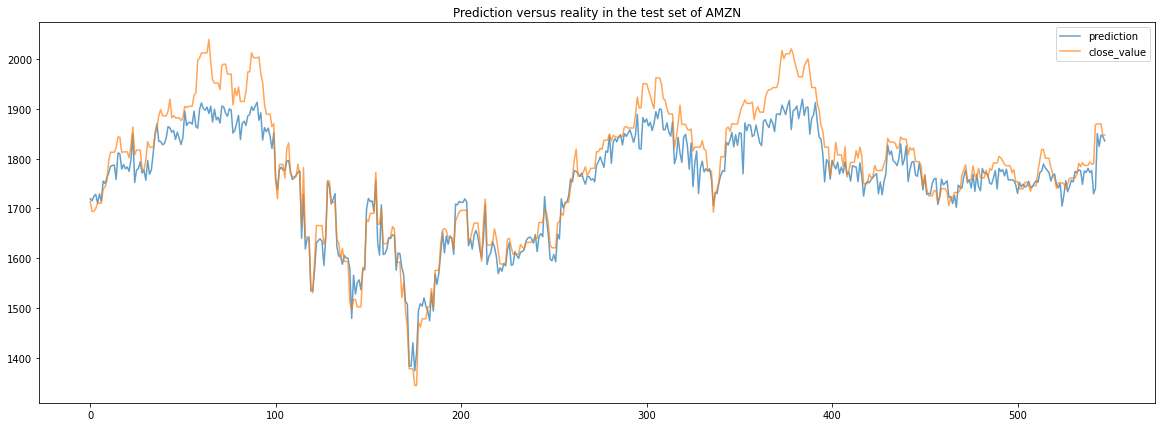

In [ ]:
AMZN = data.select("date","close_value","mean","count")
AMZNtest = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/drive/My Drive/Data/AMZN-test2.csv').select("date","close_value","mean","count")
def RF(data, test):
  trainingData = data
  testData = test
  va = VectorAssembler().setInputCols(trainingData.columns[1:4]).setOutputCol('features')
  rf = RandomForestRegressor(labelCol="close_value", featuresCol="features",maxDepth=9,numTrees=200)
  pipe = Pipeline(stages=[va, rf])
  evaluator_rf = RegressionEvaluator(labelCol="close_value", predictionCol="prediction", metricName='rmse')
  model_rf = pipe.fit(trainingData)

  # Make predictions.
  predictions = model_rf.transform(testData)

  #RMSE 
  rmse = evaluator_rf.evaluate(predictions)
  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
  print("Feature importance as of column index:",model_rf.stages[-1].featureImportances)
  ##
  return predictions,testData,rmse
predictions,testData,rmse = RF(AMZN, AMZNtest)

#Line plot comparing Prediction versus reality in the test set of AMZN
pred = predictions.toPandas()
test = testData.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(test)), test.close_value, alpha=0.7, label='close_value' );
plt.title('Prediction versus reality in the test set of AMZN')
plt.legend();

Root Mean Squared Error (RMSE) on test data = 1.32574


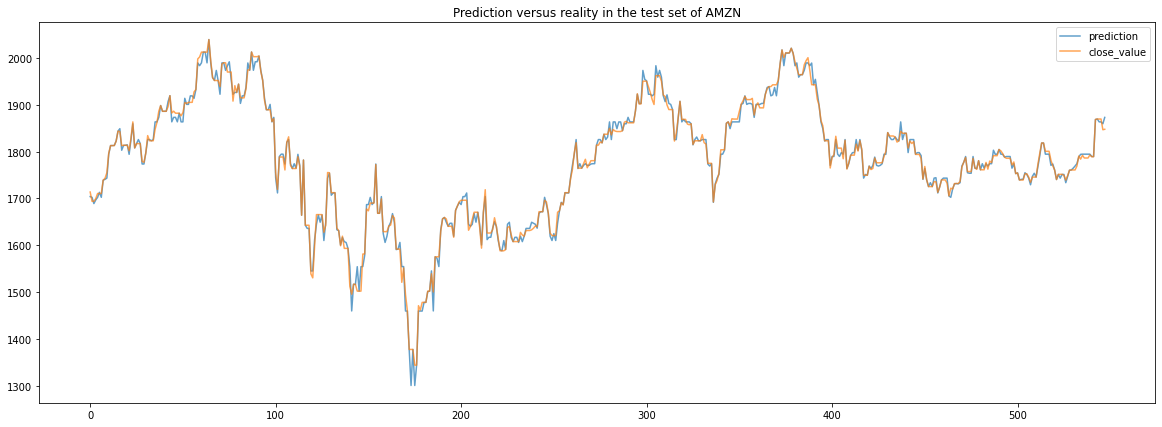

In [ ]:
from pyspark.ml.regression import GBTRegressor

def GBT(data, test):
  trainingData = data
  testData = test
  va = VectorAssembler().setInputCols(trainingData.columns[1:4]).setOutputCol('features')
  gbt = GBTRegressor(featuresCol="features",labelCol="close_value", maxIter=30,stepSize=0.0001,maxDepth=10)

  pipe = Pipeline(stages=[va, gbt])
  evaluator_gbt = RegressionEvaluator(labelCol="close_value", predictionCol="prediction", metricName='rmse')
  model_gbt = pipe.fit(trainingData)
  pred_gbt = model_gbt.transform(testData)

  rmse1_gbt = evaluator_gbt.evaluate(pred_gbt)

  print("Root Mean Squared Error (RMSE) on test data = %g" % rmse1_gbt)
  return pred_gbt,testData,rmse1_gbt

pred_gbt,testData,rmse1_gbt = GBT(AMZN, AMZNtest)

#Line plot comparing Prediction versus reality in the test set of msft
pred = pred_gbt.toPandas()
test = testData.toPandas()
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred.prediction, alpha=0.7, label='prediction')
plt.plot(np.arange(len(test)), test.close_value, alpha=0.7, label='close_value');
plt.title('Prediction versus reality in the test set of AMZN')
plt.legend();